### American Express Credit Default
#### Modeling: 

In this notebook, we will develop three models to fit the data and predict the probability of a credit default for each American Express customer. I will also perform a SMOTE to balance the classes and compare results between the 2 datasets (balanced and unbalanced)

#### Balancing datasets with oversampling: SMOTE

I will perform an oversampling technique on the minority class. Then, I will evaluate the performance of different models using the balanced classes and imbalanced classes.

In [2]:
# importing packages
import pandas as pd
import numpy as np
from sklearn. model_selection import cross_validate, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

In [3]:
#loading data
path = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/X_train_scaled.csv'
path2 = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/y_train.csv'
path3 = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/X_test.csv'
path4 = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/y_test.csv'
X_train_scaled = pd.read_csv(path)
y_train = pd.read_csv(path2)
X_test = pd.read_csv(path3)
y_test = pd.read_csv(path4)

In [4]:
# data quality
y_train.head()
y_train.drop('Unnamed: 0', axis=1, inplace=True)
y_train.value_counts()

credit_card_default
0                      29345
1                       2524
Name: count, dtype: int64

In [5]:
# checking data quality
X_train_scaled.head()

,Unnamed: 0,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,...,ot_Low-skill Laborers,ot_Managers,ot_Medicine staff,ot_Private service staff,ot_Realty agents,ot_Sales staff,ot_Secretaries,ot_Security staff,ot_Unknown,ot_waiters_barmen staff
0,0,0.96875,0.0,0.0,1.0,0.000000,0.028468,0.999970,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.68750,0.0,0.0,1.0,0.000000,0.038086,0.999986,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0.81250,0.0,0.0,1.0,0.111111,0.020265,0.005843,0.222222,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.71875,1.0,0.0,0.0,0.111111,0.056184,0.002694,0.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0.40625,1.0,1.0,0.0,0.222222,0.047061,0.020052,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_train_scaled.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# checking data quality
X_test.head(5)
X_test.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
print('X_train shape:', X_train_scaled.shape)

print('X_test shape:', X_test.shape)

X_train shape: (31869, 34)
X_test shape: (13659, 34)


In [9]:
X_test = pd.DataFrame(X_test, columns=['age', 'gender', 'owns_car', 'owns_house', 'no_of_children',
       'net_yearly_income', 'no_of_days_employed', 'total_family_members',
       'migrant_worker', 'yearly_debt_payments', 'credit_limit',
       'credit_limit_used_pctg', 'credit_score', 'prev_defaults',
       'default_in_last_6months', 'ot_Accountants', 'ot_Cleaning staff',
       'ot_Cooking staff', 'ot_Core staff', 'ot_Drivers', 'ot_HR staff',
       'ot_High skill tech staff', 'ot_IT staff', 'ot_Laborers',
       'ot_Low-skill Laborers', 'ot_Managers', 'ot_Medicine staff',
       'ot_Private service staff', 'ot_Realty agents', 'ot_Sales staff',
       'ot_Secretaries', 'ot_Security staff', 'ot_Unknown',
       'ot_waiters_barmen staff'])

In [10]:
# converting y_train 1D array
y_train.columns
y_train = y_train.credit_card_default

In [11]:
y_train.shape

(31869,)

In [12]:
# cleaning up y_test 
y_test.shape
y_test.head(5)
y_test = y_test.drop('Unnamed: 0', axis=1)

In [13]:

# converting y_test 1D array
y_test.shape
y_test = y_test.credit_card_default

In [14]:
y_test.shape

(13659,)

The classes are imbalanced in a ratio of 1:11. I will oversample the minority class to a 1:2 ratio. The imblearn SMOTE documentation suggests using an undersampling technique improves the performance. Therefore, I will test both methods. I am going to start with the simple SMOTE alone. 

#### MODEL 1: SMOTE with Random Forest Classifier

In [28]:
# using SimpleImputer to replace nan values with median in train set
imputer = SimpleImputer(strategy='median',
                   missing_values=np.nan)
imputer = imputer.fit(X_train_scaled)
X_train_scaled = imputer.transform(X_train_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=['age', 'gender', 'owns_car', 'owns_house', 'no_of_children',
       'net_yearly_income', 'no_of_days_employed', 'total_family_members',
       'migrant_worker', 'yearly_debt_payments', 'credit_limit',
       'credit_limit_used_pctg', 'credit_score', 'prev_defaults',
       'default_in_last_6months', 'ot_Accountants', 'ot_Cleaning staff',
       'ot_Cooking staff', 'ot_Core staff', 'ot_Drivers', 'ot_HR staff',
       'ot_High skill tech staff', 'ot_IT staff', 'ot_Laborers',
       'ot_Low-skill Laborers', 'ot_Managers', 'ot_Medicine staff',
       'ot_Private service staff', 'ot_Realty agents', 'ot_Sales staff',
       'ot_Secretaries', 'ot_Security staff', 'ot_Unknown',
       'ot_waiters_barmen staff'])

# oversampling by smote
sm = SMOTE(random_state = 42)
# fitting model
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
# checking data quality
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
#checking data quality
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


After OverSampling, the shape of train_X: (58690, 34)
After OverSampling, the shape of train_y: (58690,) 

After OverSampling, counts of label '1': 29345
After OverSampling, counts of label '0': 29345


In [29]:
X_train_res.shape

(58690, 34)

In [30]:
y_train_res.shape

(58690,)

In [31]:
X_test.shape

(13659, 34)

In [32]:
# defining model Random Forest Classifier object
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
# fitting model to data 
model_rf = rf.fit(X_train_res, y_train_res)
# creating pipeline object
y_pred = model_rf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.971
Random Forest: f1-score=0.969


/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Confusion matrix, without normalization
[[12486     0]
 [  393   780]]


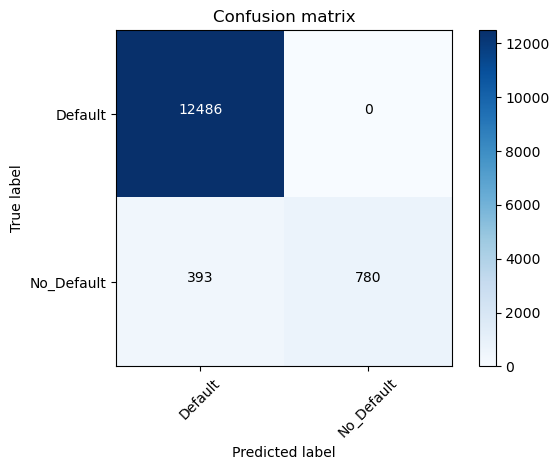

In [33]:
import itertools

import matplotlib.pyplot as plt


# class names
class_names = ['Default', 'No_Default']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm=cm, classes=class_names,
                      title='Confusion matrix')
#plt.savefig('figures/RF_cm_multi_class.png')

#### Tunning the RF Model 1



In [34]:
# creating hyperparameters for tunning

n_est =[int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
max_d = [int(x) for x in np.linspace(start = 1, stop = 100, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_est,
           'max_depth': max_d,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'criterion': ['gini', 'entropy']
           }
rf_ = RandomForestClassifier()
rf_rscv = RandomizedSearchCV(rf, param_distributions=random_grid, n_iter=20, n_jobs=-1, cv=5, random_state=42)
rf_rscv.fit(X_train_res, y_train_res)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=42)

In [35]:
#printing best params                         
print("Best Estimator:" + str(rf_rscv.best_estimator_))
print("Best Parameters: " + str(rf_rscv.best_params_))

Best Estimator:RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=138,
                       n_jobs=-1, random_state=42)
Best Parameters: {'n_estimators': 138, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}


##### Evaluating the Random Search RF Model performance:

In [36]:
# fitting the model with the parameters form GridSearchCV
rf_rscv = RandomForestClassifier(n_estimators=138, max_depth=50, min_samples_leaf=5)
rf_rscv.fit(X_train_res, y_train_res)
y_pred_rf = rf_rscv.predict(X_test)
f1_rf_cv = f1_score(y_test, y_pred_rf, average='weighted')
cm1 = confusion_matrix(y_test, y_pred_rf)

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [25]:
# classification report of rf_cv model
clreport = classification_report(y_test, y_pred_rf)
print(clreport)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     12486
           1       1.00      0.60      0.75      1173

    accuracy                           0.97     13659
   macro avg       0.98      0.80      0.86     13659
weighted avg       0.97      0.97      0.96     13659



Confusion matrix, without normalization
[[12486     0]
 [  499   674]]


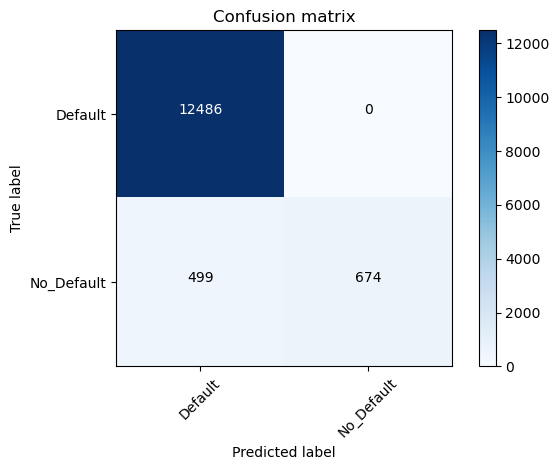

In [ ]:
# plot of confusion matrix of RF_CV Model
plt.figure()
plot_confusion_matrix(cm=cm1, classes=class_names,
                      title='Confusion matrix')
plt.show()

#### MODEL 2: Logistic Regression for Classification

In [47]:
from sklearn.linear_model import LogisticRegression
# instantiate model with logistic regression
logreg = LogisticRegression(random_state=42, max_iter=500)
# fitting the data to the model
logreg.fit(X_train_res, y_train_res)
# predicting binary labels
y_pred = logreg.predict(X_test)
# printing results
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm2 = confusion_matrix(y_test, y_pred)

print('Logistic Regression: Accuracy=%.3f' % (ac))
print('Logistic Regression: f1-score=%.3f' % (f1))

Logistic Regression: Accuracy=0.914
Logistic Regression: f1-score=0.873


In [48]:
clr_report = classification_report(y_test, y_pred)
print(clr_report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     12486
           1       0.00      0.00      0.00      1173

    accuracy                           0.91     13659
   macro avg       0.46      0.50      0.48     13659
weighted avg       0.84      0.91      0.87     13659



Confusion matrix, without normalization
[[12486     0]
 [ 1173     0]]


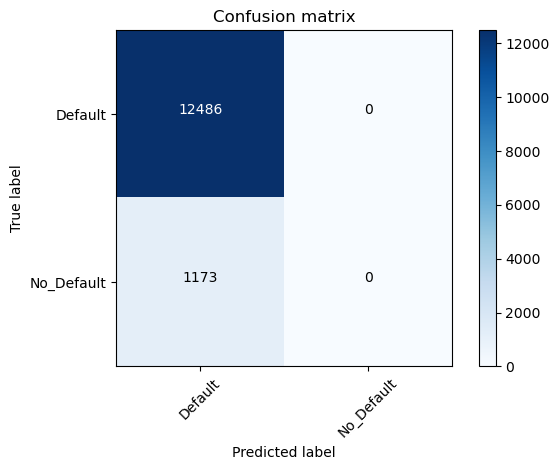

In [38]:
# plotting confussion matrix
plt.figure()
plot_confusion_matrix(cm=cm2, classes=class_names,
                      title='Confusion matrix')
plt.show()

#### Tunning Model 2: Logistic Regression

In [39]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 8


In [40]:
import warnings
warnings.filterwarnings('ignore')

# tunning with GridSearchCV
Cs = [0.001, 0.1, 1, 10, 50, 100]
parameters = {
    'penalty':['l1','l2'], 
    'C': Cs,
    'solver':['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter':[int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
}
# creating model
clrgs=LogisticRegression()
clrgs_cv = GridSearchCV(clrgs,
                   param_grid=parameters,
                   scoring='f1_weighted',
                   cv=5, n_jobs=n_cpu-1)
#training the model
clrgs_cv.fit(X_train_res, y_train_res)
# best parametters and accuracy
print('Best hyperparameters:', clrgs_cv.best_params_)
print('Best f1 Score:', clrgs_cv.best_score_)

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Best hyperparameters: {'C': 1, 'max_iter': 277, 'penalty': 'l1', 'solver': 'liblinear'}
Best f1 Score: 0.9642141148902195


In [41]:
print('Best hyperparameters:', clrgs_cv.best_params_)
print('Best f1 Score:', clrgs_cv.best_score_)

Best hyperparameters: {'C': 1, 'max_iter': 277, 'penalty': 'l1', 'solver': 'liblinear'}
Best f1 Score: 0.9642141148902195


##### Evaluating the GridSearchCV Logistic Regression Model performance:

In [49]:
# instantiate LogisticRegression model with best_params_
clr_gs = LogisticRegression(C=1, max_iter= 277, penalty='l1', solver= 'liblinear', random_state=42)
clr_gs.fit(X_train_res, y_train_res)
y_pred_clr = clr_gs.predict(X_test)
f1_clr = f1_score(y_test, y_pred_clr, average='weighted')
cm3 = confusion_matrix(y_test, y_pred_clr)
ac_clr = accuracy_score(y_test, y_pred_clr)


print('Logistic Regression: Accuracy=%.3f' % (ac_clr))
print('Logistic Regression: f1-score=%.3f' % (f1_clr))

Logistic Regression: Accuracy=0.862
Logistic Regression: f1-score=0.862


In [50]:
clrgs_report = classification_report(y_test, y_pred_clr)
print(clrgs_report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     12486
           1       0.20      0.20      0.20      1173

    accuracy                           0.86     13659
   macro avg       0.56      0.56      0.56     13659
weighted avg       0.86      0.86      0.86     13659



Confusion matrix, without normalization
[[11545   941]
 [  944   229]]


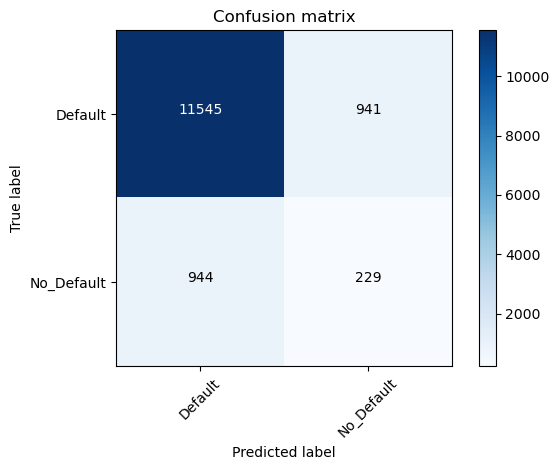

In [51]:
# plotting confusion matrix of Logistic Regression model
plt.figure()
plot_confusion_matrix(cm=cm3, classes=class_names,
                      title='Confusion matrix')
plt.show()

#### MODEL 3: KNN Classifier

I will build a KNN default model and apply cross-validation. Then, I will perform hyperparameter tunning for the model and evaluate the best_params_ of the search. 

In [66]:
# evaluating n_neighbors variance
test_scores = []
train_scores = []

for i in range(1,10):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train_res,y_train_res)
    
    train_scores.append(knn.score(X_train_res,y_train_res))
    test_scores.append(knn.score(X_test,y_test))

In [89]:
type(knn)

sklearn.neighbors._classification.KNeighborsClassifier

In [67]:
# printing train and test scores of default KNN Classifier
for i, x in zip(train_scores, test_scores):
      print(f'K: {train_scores.index(i)+1} \nTrain Score: {i} \nTest Score: {x}') 

K: 1 
Train Score: 1.0 
Test Score: 0.9141225565561168
K: 2 
Train Score: 0.9991139887544727 
Test Score: 0.9141225565561168
K: 3 
Train Score: 0.9883796217413529 
Test Score: 0.9141225565561168
K: 4 
Train Score: 0.9894530584426648 
Test Score: 0.9141225565561168
K: 5 
Train Score: 0.9825694326120293 
Test Score: 0.9141225565561168
K: 6 
Train Score: 0.9838473334469245 
Test Score: 0.9141225565561168
K: 7 
Train Score: 0.9782245697733856 
Test Score: 0.9141225565561168
K: 8 
Train Score: 0.979706934741864 
Test Score: 0.9141225565561168
K: 9 
Train Score: 0.9746634861134776 
Test Score: 0.9141225565561168


In [69]:
# KNN Model with default hyperparameters
knn_model = KNeighborsClassifier(n_neighbors=2)
# fit the data to the model and perform cross-validation
knn_model.fit(X_train_res, y_train_res)
y_pred_knn = knn_model.predict(X_test)
f1_knn = f1_score(y_test, y_pred_clr, average='weighted')
cm4 = confusion_matrix(y_test, y_pred_knn)
ac_knn = accuracy_score(y_test, y_pred_knn)


print('f1 kNN Default:', f1_knn)
print('Accuracy kNN Default:', ac_knn)

f1 kNN Default: 0.8619156912688805
Accuracy kNN Default: 0.9141225565561168


In [70]:
# classification report
clrgs_report = classification_report(y_test, y_pred_knn)
print(clrgs_report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     12486
           1       0.00      0.00      0.00      1173

    accuracy                           0.91     13659
   macro avg       0.46      0.50      0.48     13659
weighted avg       0.84      0.91      0.87     13659



Confusion matrix, without normalization
[[12486     0]
 [ 1173     0]]


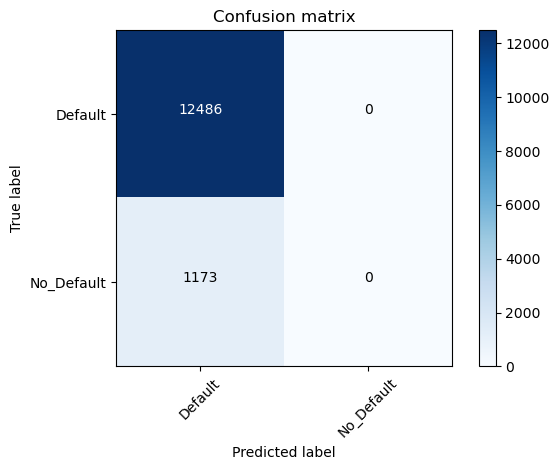

In [71]:
# plotting confussion matrix of KNN Model
plt.figure()
plot_confusion_matrix(cm=cm4, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [99]:
# instantiate GridSearch CV
param_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 35 , num = 30)], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
knn_gscv = GridSearchCV(knn, 
        param_grid=param_grid,
        scoring='f1_weighted',
         n_jobs=n_cpu-1,
            cv=5)
knn_modelgscv = knn_gscv.fit(X_train_res, y_train_res)

In [100]:
# printing best score and best params
print('Best hyperparameters:', knn_modelgscv.best_params_)
print('Best f1 Score:', knn_modelgscv.best_score_)

Best hyperparameters: {'n_neighbors': 2, 'weights': 'uniform'}
Best f1 Score: 0.9839653166612521


#### Evaluating GridSearchCV with KNN Model

In [102]:
knn_model_gscv = KNeighborsClassifier(n_neighbors=2, weights='uniform')
knn_model_gscv.fit(X_train_res, y_train_res)
y_pred_knn2 = knn_model_gscv.predict(X_test)
f1_clr = f1_score(y_test, y_pred_clr, average='weighted')
cm5 = confusion_matrix(y_test, y_pred_knn2)
ac_clr = accuracy_score(y_test, y_pred_knn2)


print('Logistic Regression: Accuracy=%.3f' % (ac_clr))
print('Logistic Regression: f1-score=%.3f' % (f1_clr))

Logistic Regression: Accuracy=0.914
Logistic Regression: f1-score=0.862


In [103]:
# classification report
clknn_report = classification_report(y_test, y_pred_knn2)
print(clknn_report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     12486
           1       0.00      0.00      0.00      1173

    accuracy                           0.91     13659
   macro avg       0.46      0.50      0.48     13659
weighted avg       0.84      0.91      0.87     13659



Confusion matrix, without normalization
[[12486     0]
 [ 1173     0]]


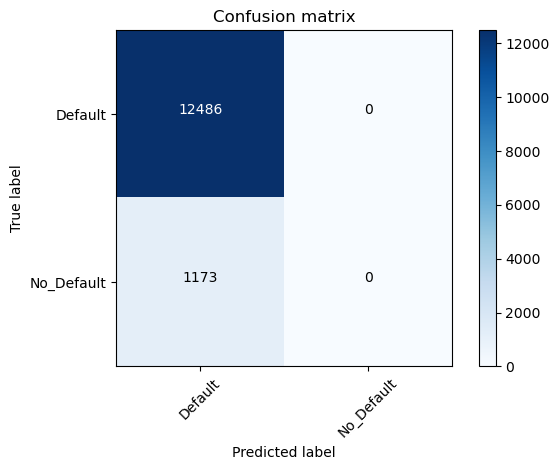

In [104]:
# plotting confussion matrix of KNN Model
plt.figure()
plot_confusion_matrix(cm=cm5, classes=class_names,
                      title='Confusion matrix')
plt.show()